In [147]:
db_path = 'datasets/aqw.db'

cnx = sqlite3.connect(db_path)

In [148]:
# to compute distances based on coordinates
from math import atan2, cos, radians, sin, sqrt

def great_circle_distance(point1: tuple[float, float], point2: tuple[float, float]) -> float:
    """
    Uses the haversine formula to compute the distance (m) between two
    points (latitude, longitude) in coordinates (in degrees).
    Adapted from http://www.movable-type.co.uk/scripts/latlong.html.
    :param point1: tuple whose first item represents the latitude, and
        its second item the longitude of a point in degrees
    :param point2: tuple whose first item represents the latitude, and
        its second item the longitude of a point in degrees
    :return: great-circle distance between the two points in meters
    """
    r = 6371e3  # radius of the earth, in meters

    latitude1_deg, longitude1_deg = point1  # in degrees
    latitude2_deg, longitude2_deg = point2  # in degrees

    latitude1_rad = radians(latitude1_deg)  # in radians
    latitude2_rad = radians(latitude2_deg)  # in radians

    latitude_delta = radians(latitude2_deg - latitude1_deg)
    longitude_delta = radians(longitude2_deg - longitude1_deg)

    a = sin(latitude_delta / 2) ** 2 + cos(latitude1_rad) * cos(latitude2_rad) * sin(longitude_delta / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return r * c


Some of the code provided in this notebook requires the geopandas library. Unfortunately, it
doesn’t work well with the default environment in Anaconda. To get it running, follow the following
steps:
<ol>
    <li>Make sure jupyter notebook and Anaconda are not running.</li>
    <li>Open Anaconda Navigator.</li>
    <li>Go to Environments (on the left).</li>
    <li>Click on “Import” (button near the bottom).</li>
    <li>Click on the folder icon next to “Local drive”.</li>
    <li>Select “Conda explicit specification files (*.txt)” in the drop-down in the bottom right-hand corner.</li>
    <li>Navigate to the folder where you extracted the files from the GA2 zip archive.</li>
    <li>Select geopandas-spec.txt and click “Open”.</li>
    <li>Click “Import”. Now Anaconda will create a new environment with the required packages. This may take some time.</li>
    <li>Go back to Home (on the left).</li>
    <li>You can now run jupyter notebook from here as normally. On restarts, make sure your new environment (“geopandas-spec”) selected at the top.</li>
</ol>
If you run into any issues with this, please ask your tutor for help.

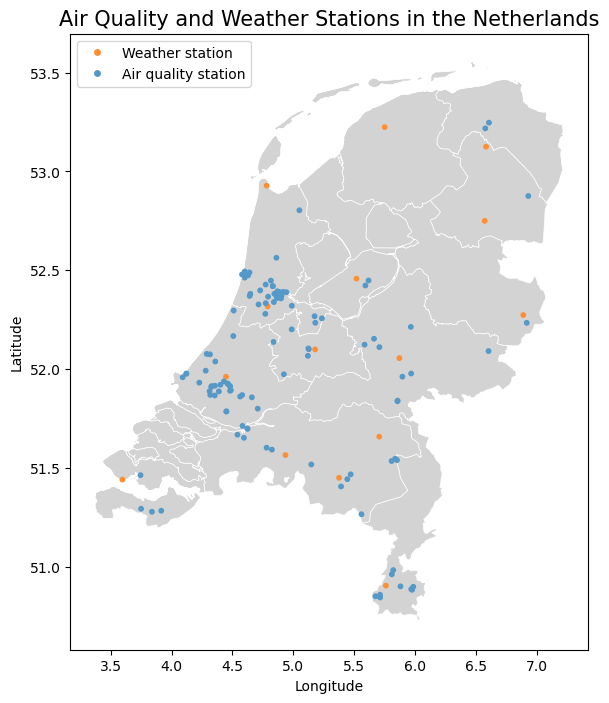

In [149]:
#Weather and Air Quality Map of NL
from matplotlib.lines import Line2D
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3

def plot_stations_on_map(df_stations):
    map_nl = gpd.read_file('./datasets/stanford-st293bj4601-shapefile.zip')

    gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(df_stations['longitude'], df_stations['latitude'])])
    gdf['color'] = list(df_stations['color'])
    gdf.crs = map_nl.crs

    f, ax = plt.subplots(1, figsize=(8, 8))

    map_nl.plot(linewidth=0.5, edgecolor='white', color='lightgrey',legend=True, ax=ax)
    gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=10)

    ax.set_title('Air Quality and Weather Stations in the Netherlands', size=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    legend = [
        Line2D([0], [0], markerfacecolor='#FF8F35', marker='o', color='w', label='Weather station'),
        Line2D([0], [0], markerfacecolor='#5499C7', marker='o', color='w', label='Air quality station')
    ]
    ax.legend(handles=legend, loc='upper left')
    return ax
    
def all_stations():
    aqs_sql = "SELECT * FROM air_quality_stations"
    ws_sql = "SELECT * FROM weather_stations"
    with sqlite3.connect('./datasets/aqw.db') as conn:
        df_aqs = pd.read_sql_query(aqs_sql, conn)
        df_ws = pd.read_sql_query(ws_sql, conn)
    df_aqs['color'] = "#5499c7"
    df_ws['color'] = "#ff8f35"
    return pd.concat([df_ws, df_aqs])

plot_stations_on_map(all_stations());

In [159]:
import warnings
warnings.filterwarnings('ignore')

In [150]:
compound = 'pm_25'

df = all_stations()

In [136]:
QUERY_AQ = f"""
    SELECT *
    FROM air_quality_data 
"""
df_aq = pd.read_sql_query(QUERY_AQ, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

QUERY_WEATHER = f"""
    SELECT *
    FROM weather_data 
"""
df_weather = pd.read_sql_query(QUERY_WEATHER, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

In [276]:
import numpy as np

df_stations = all_stations()

X = df_stations[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

df_stations['cluster'] = kmeans.labels_

for i in range(2):
    clust = df_stations[df_stations['cluster'] == i][['latitude', 'longitude']]
    centroid = kmeans.cluster_centers_[i]
    dst = np.sqrt(((clust - centroid) ** 2).sum(axis=1))
    idx = dst.idxmin()
    a = df_stations[df_stations['color'] == "#5499c7"].loc[idx]
    print(f"Cluster {i} lat {a['latitude']} long {a['longitude']}")
    print(idx)
    
    QUERY_WEATHER_STATION = f"""
        SELECT aq_station_code, weather_station_code, distance 
        FROM close_stations 
        WHERE aq_station_code='{a['code']}' 
        GROUP BY aq_station_code
    """
    closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION, cnx).squeeze()
    print(df_stations[df_stations['code'] == int(closest_weather_info['weather_station_code'])].index)

Cluster 0 lat 52.167753 long 4.50756
108
Index([10], dtype='int64')
Cluster 1 lat 51.841372 long 5.857777
19
Index([13], dtype='int64')


In [220]:
df_plot = pd.concat([(df_stations.loc[[108, 19]]), (df_stations[(df_stations['code'] == 344) | (df_stations['code'] == 375)])])

In [313]:
(df_stations[df_stations['latitude'] < 51])

,code,name,latitude,longitude,color,cluster
14,380,Maastricht,50.906000,5.762000,#ff8f35,0
3,NL10136,Heerlen-Looierstraat,50.887959,5.970496,#5499c7,0
4,NL10138,Heerlen-Jamboreepad,50.900317,5.986853,#5499c7,0
24,NL10133,Wijnandsrade-Opfergeltstraat,50.902281,5.881748,#5499c7,0
72,NL10137,Heerlen-Deken Nicolayestraat,50.884870,5.977283,#5499c7,0
85,NL50003,Geleen-Asterstraat,50.984447,5.822233,#5499c7,0
86,NL50004,Maastricht-A2 Nassaulaan,50.845941,5.714745,#5499c7,0
90,NL50002,Geleen-Vouershof,50.963087,5.810702,#5499c7,0
92,NL50007,Maastricht-Hoge Fronten,50.852049,5.675796,#5499c7,0
93,NL50009,Maastricht-A2 Kasteel Hillenraadweg,50.859810,5.713810,#5499c7,0


<Axes: title={'center': 'Air Quality and Weather Stations in the Netherlands'}, xlabel='Longitude', ylabel='Latitude'>

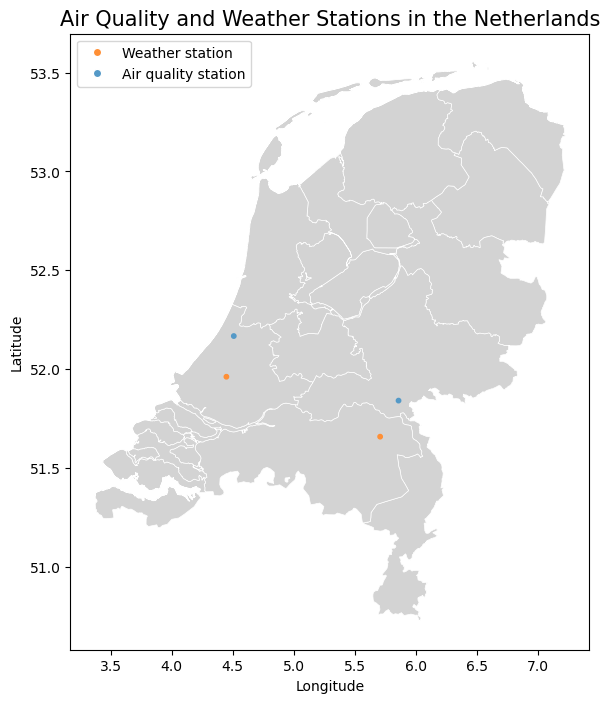

In [301]:
plot_stations_on_map(df_plot)

In [277]:
df_stations = all_stations()

X = df_stations[['latitude']]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
df_stations['cluster'] = kmeans.labels_

for i in range(2):
    clust = df_stations[df_stations['cluster'] == i][['latitude']]
    centroid = kmeans.cluster_centers_[i]
    dst = np.abs(clust['latitude'] - centroid)
    idx = dst.idxmin()
    a = df_stations[df_stations['color'] == "#5499c7"].loc[idx]
    print(f"Cluster {i}")
    print(f"idx {idx}")
    
    QUERY_WEATHER_STATION = f"""
        SELECT aq_station_code, weather_station_code, distance 
        FROM close_stations 
        WHERE aq_station_code='{a['code']}' 
        GROUP BY aq_station_code
    """
    closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION, cnx).squeeze()
    print(a['code'])
    print(int(closest_weather_info['weather_station_code']))
    print(df_stations[df_stations['code'] == int(closest_weather_info['weather_station_code'])].index)

Cluster 0
idx 75
NL10547
260
Index([2], dtype='int64')
Cluster 1
idx 7
NL10247
370
Index([12], dtype='int64')


In [278]:
b = df_stations[(df_stations['code'] == 'NL10547') | (df_stations['code'] == 'NL10247') | \
                (df_stations['code'] == 260) | (df_stations['code'] == 370)]

<Axes: title={'center': 'Air Quality and Weather Stations in the Netherlands'}, xlabel='Longitude', ylabel='Latitude'>

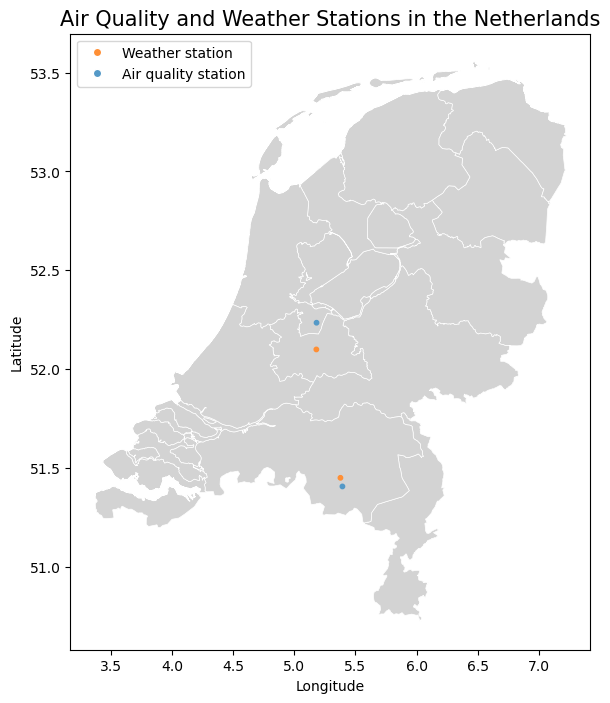

In [300]:
plot_stations_on_map(b)

In [297]:
df_stations = all_stations()

X = df_stations[['latitude']]
df_stations['cluster'] = (df_stations['latitude'] > 52).astype(int)

for i in range(2):
    clst = df_stations[df_stations['cluster'] == i][['latitude']]
    centroid = clst['latitude'].mean()
    dst = np.abs(clst['latitude'] - centroid)
    idx = dst.idxmin()
    a = df_stations[df_stations['color'] == "#5499c7"].loc[idx]
    print(f"Cluster {i}")
    print(f"idx {idx}")
    
    QUERY_WEATHER_STATION = f"""
        SELECT aq_station_code, weather_station_code, distance 
        FROM close_stations 
        WHERE aq_station_code='{a['code']}' 
        GROUP BY aq_station_code
    """
    closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION, cnx).squeeze()
    print(a['code'])
    print(int(closest_weather_info['weather_station_code']))
    print(df_stations[df_stations['code'] == int(closest_weather_info['weather_station_code'])].index)

Cluster 0
idx 52
NL10241
350
Index([11], dtype='int64')
Cluster 1
idx 42
NL49016
240
Index([1], dtype='int64')


In [298]:
c = df_stations[(df_stations['code'] == 'NL10241') | (df_stations['code'] == 'NL49016') | \
                (df_stations['code'] == 350) | (df_stations['code'] == 240)]

<Axes: title={'center': 'Air Quality and Weather Stations in the Netherlands'}, xlabel='Longitude', ylabel='Latitude'>

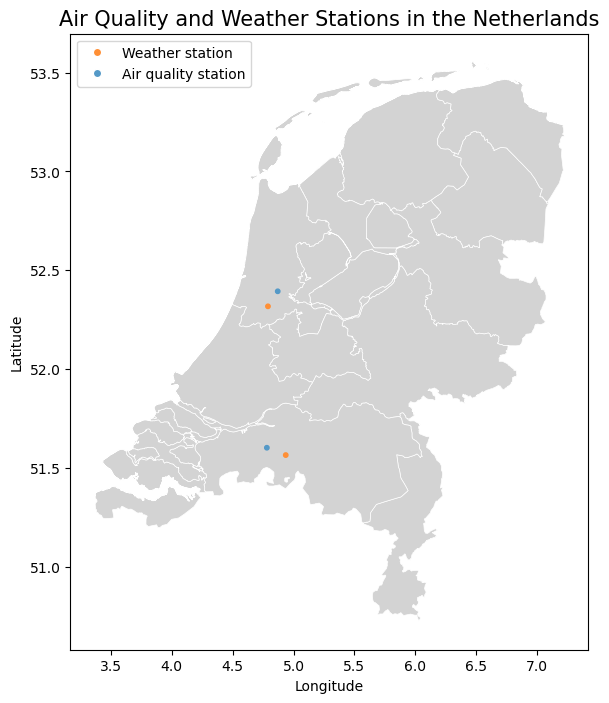

In [299]:
plot_stations_on_map(c)

In [96]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df['week'] = df['day_of_year'] // 7 + 1
df['hour'] = df.index.hour

In [97]:
df.head()

,pm_25,wind_direction,wind_speed,wind_gust,temperature,sunshine_duration,global_radiation,precipitation,air_pressure,visibility,...,fog,rainfall,snow,thunder,ice_formation,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00+01:00,NaN,220,7.0,11.0,10.7,0.0,0.0,-1.0,1011.6,59.0,...,0,1,0,0,0,2012,1,1,1,0
2012-01-01 01:00:00+01:00,116.3,230,7.0,11.0,10.8,0.0,0.0,0.0,1011.7,60.0,...,0,0,0,0,0,2012,1,1,1,1
2012-01-01 02:00:00+01:00,2.1,230,7.0,10.0,10.6,0.0,0.0,-1.0,1011.6,34.0,...,0,1,0,0,0,2012,1,1,1,2
2012-01-01 03:00:00+01:00,3.6,220,7.0,11.0,10.5,0.0,0.0,1.7,1011.5,49.0,...,0,1,0,0,0,2012,1,1,1,3
2012-01-01 04:00:00+01:00,5.7,210,7.0,11.0,10.6,0.0,0.0,1.0,1011.1,65.0,...,0,1,0,0,0,2012,1,1,1,4


In [36]:
cnx.close()